In [1]:
import numpy as np


def globalStiffnessMatrix(E, b, x0, L, N):
    A = 0.0341
    gMatrix = np.zeros(shape=[N, N])
    EI = E * A
    h = abs(L - x0) / (N - 1)

    for i in range(gMatrix.shape[0] - 1):
        buffMatrix = np.zeros(shape=[N, N])
        buffMatrix[i:i + 2, i: i + 2] = [[1, -1], [-1, 1]]
        gMatrix += buffMatrix

    gMatrix[0][1] = 0
    gMatrix[1][0] = 0

    gMatrix = gMatrix * (EI / h)

    return gMatrix


def loadVector(P, p, g, E, b, x0, L, N):
    A = 0.0341
    pMatrix = np.zeros(shape=[N, N])
    fVector = np.zeros(shape=[N, 1])

    h = abs(L) / (N - 1)

    for i in range(pMatrix.shape[0] - 1):
        buffMatrix = np.zeros(shape=[N, N])
        buffMatrix[i:i + 2, i: i + 2] = [[2, 1], [1, 2]]
        pMatrix += buffMatrix
        fVector[i] = p * g * A

    fVector[N - 1] = p * g * A

    pMatrix[0] = np.zeros(shape=N)

    pMatrix = pMatrix * -h / 6

    return pMatrix.dot(fVector)


def finiteElementMethod(P, p, g, E, b, x0, L, N):
    stiffnessMatrix = globalStiffnessMatrix(E, b, x0, L, N)
    loadV = loadVector(P, p, g, E, b, x0, L, N)

    loadV[N - 1] += (-P)
    uVector = (np.linalg.inv(stiffnessMatrix)).dot(loadV)

    return uVector, stiffnessMatrix


def ksiFun(xArr, yCoeffArr, x0, L):
    xVector = np.linspace(x0, L, yCoeffArr.shape[0])
    arrAns = np.zeros(shape=xArr.shape)

    for index, i in enumerate(xArr):
        j = 1
        while (i > xVector[j]):
            j += 1

        b = - (xVector[j] * yCoeffArr[j - 1] - xVector[j - 1] * yCoeffArr[j]) / (xVector[j - 1] - xVector[j])
        k = -(-yCoeffArr[j - 1] + yCoeffArr[j]) / (xVector[j - 1] - xVector[j])
        arrAns[index] = k * i + b

    return arrAns


In [2]:
from solveFun import np


def ansFun2(xArr, E, P, p, g, L):
    A = 0.0341
    Cx = E * A
    fx = p * g * A
    # return -0.0000328408 * xArr + 3.51525 * 1e-7 * np.power(xArr, 2)
    return fx / Cx * np.power(xArr, 2) / 2 + (-P / Cx - (fx / Cx * L)) * xArr


def infNorma(Yans, Yorig):
    absmax = np.max(np.abs(Yans - Yorig))
    infmax = absmax / np.max(np.abs(Yorig))
    return infmax, absmax


def l2Norm(Yans, Yorig):
    sum = np.sum(np.power(Yans - Yorig, 2))
    ans = np.power(sum / np.sum(np.power(Yorig, 2)), 1 / 2)
    return ans


In [3]:
import time
import pandas as pd
import matplotlib.pyplot as plt

def main():
    E = 30 * 1e9
    P = 30000
    L = 5
    b = 0.1
    p = 2150
    g = 9.81
    x0 = 0

    Ni = [2, 4, 8, 16, 32, 64, 128]
    arrAns = np.zeros(shape=[len(Ni), 7])

    i = 0
    for N in Ni:
        start_time = time.time()

        uVector, stiffnessMatrix = finiteElementMethod(P, p, g, E, b, x0, L, N)

        times = time.time() - start_time

        Q = 10000

        xVector = np.linspace(x0, L, Q)
        yArrAns = ksiFun(xVector, uVector, x0, L)
        yOrig = ansFun2(xVector, E, P, p, g, L)

        infmax, absmax = infNorma(yArrAns, yOrig)

        Erl = l2Norm(yArrAns, yOrig)

        arrAns[i][0] = N
        arrAns[i][1] = infmax
        arrAns[i][3] = Erl
        arrAns[i][5] = np.linalg.cond(stiffnessMatrix)
        arrAns[i][6] = times

        if (i != 0):
            R1 = np.log2(arrAns[i - 1][1] / infmax)
            R2 = np.log2(arrAns[i - 1][3] / Erl)
            arrAns[i][2] = R1
            arrAns[i][4] = R2

        i += 1

        plt.figure(figsize=(15, 10))
        plt.xlabel("X", fontsize=14)
        plt.ylabel("Y", fontsize=14)
        plt.rcParams['font.size'] = '14'
        plt.plot(xVector, yOrig, label="exact solution", color='red')
        plt.scatter(xVector, yArrAns, marker='^', label="approximate solution for N = " + str(N))
        plt.legend()
        plt.grid(True)
        plt.show()
    return arrAns

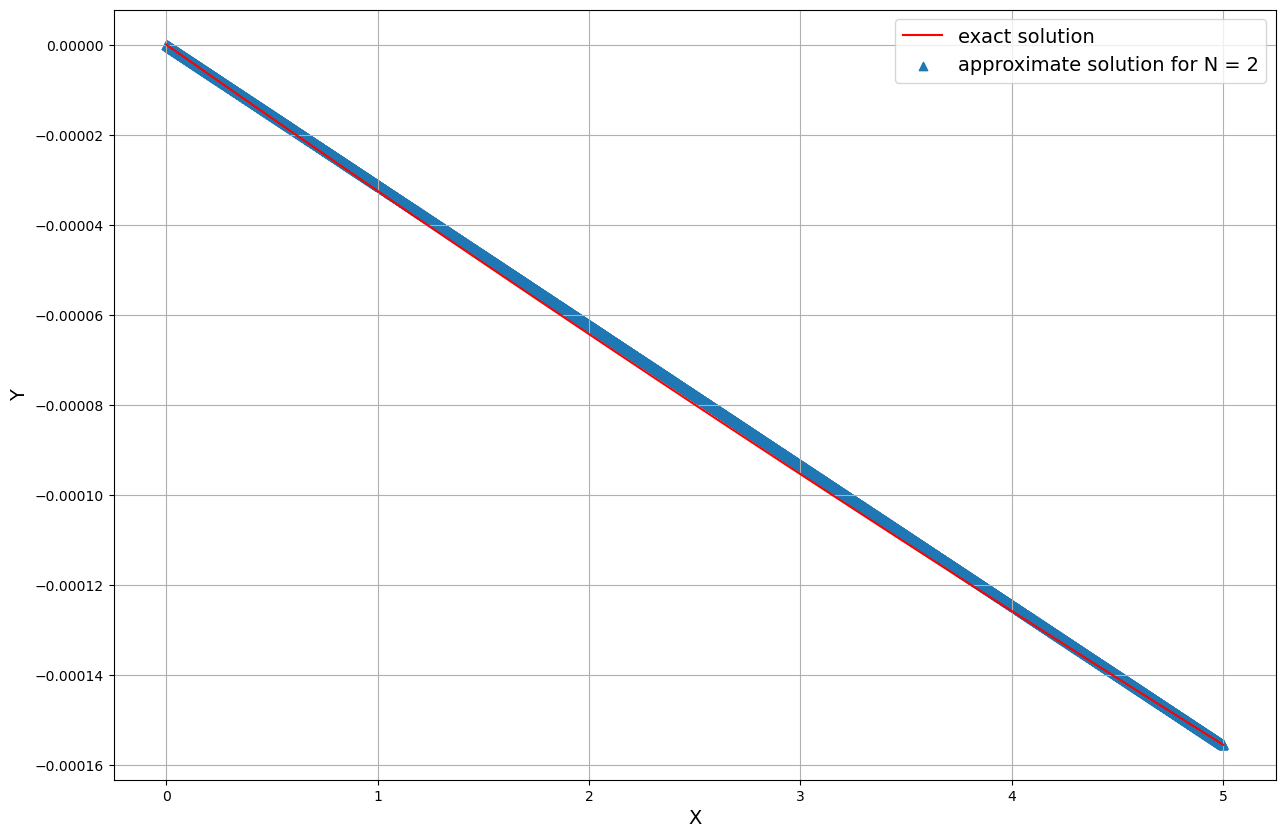

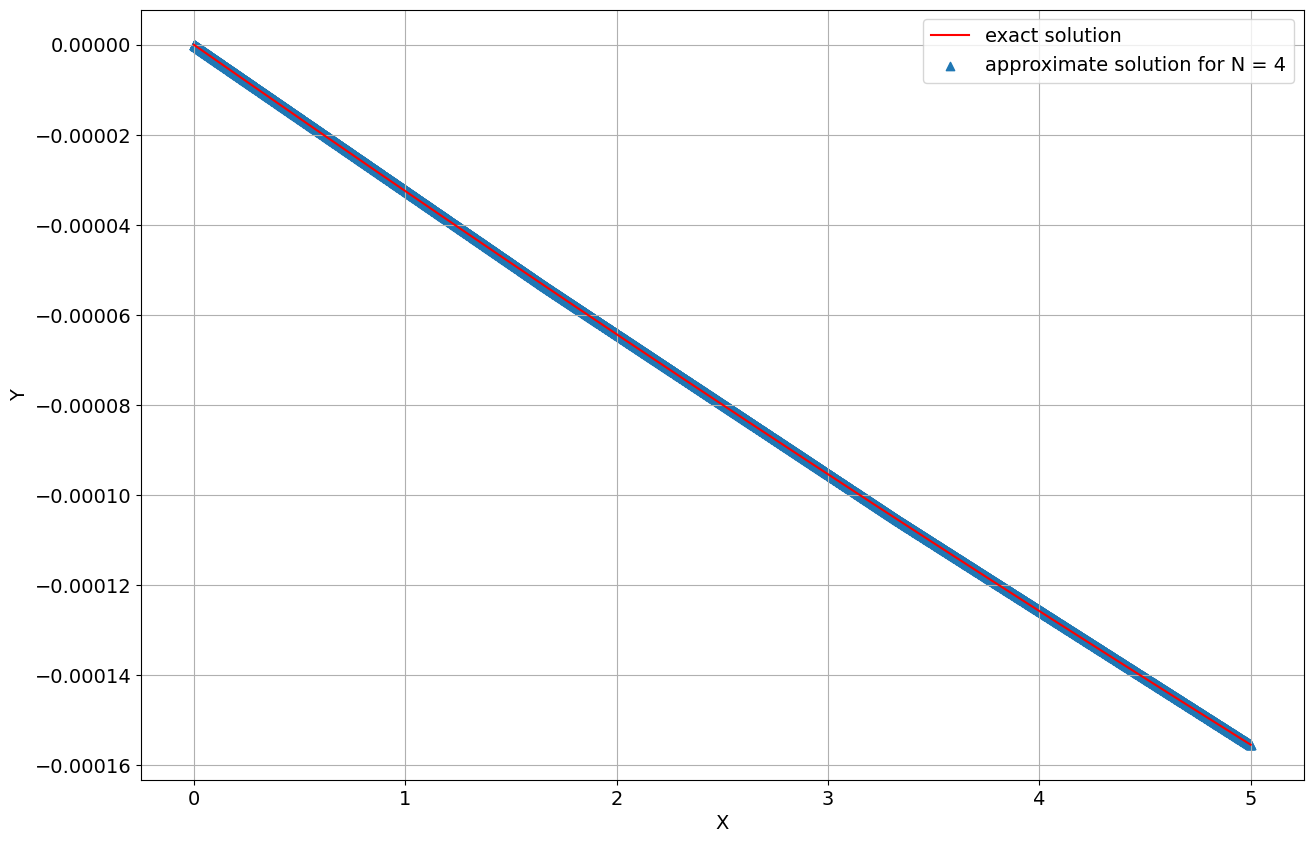

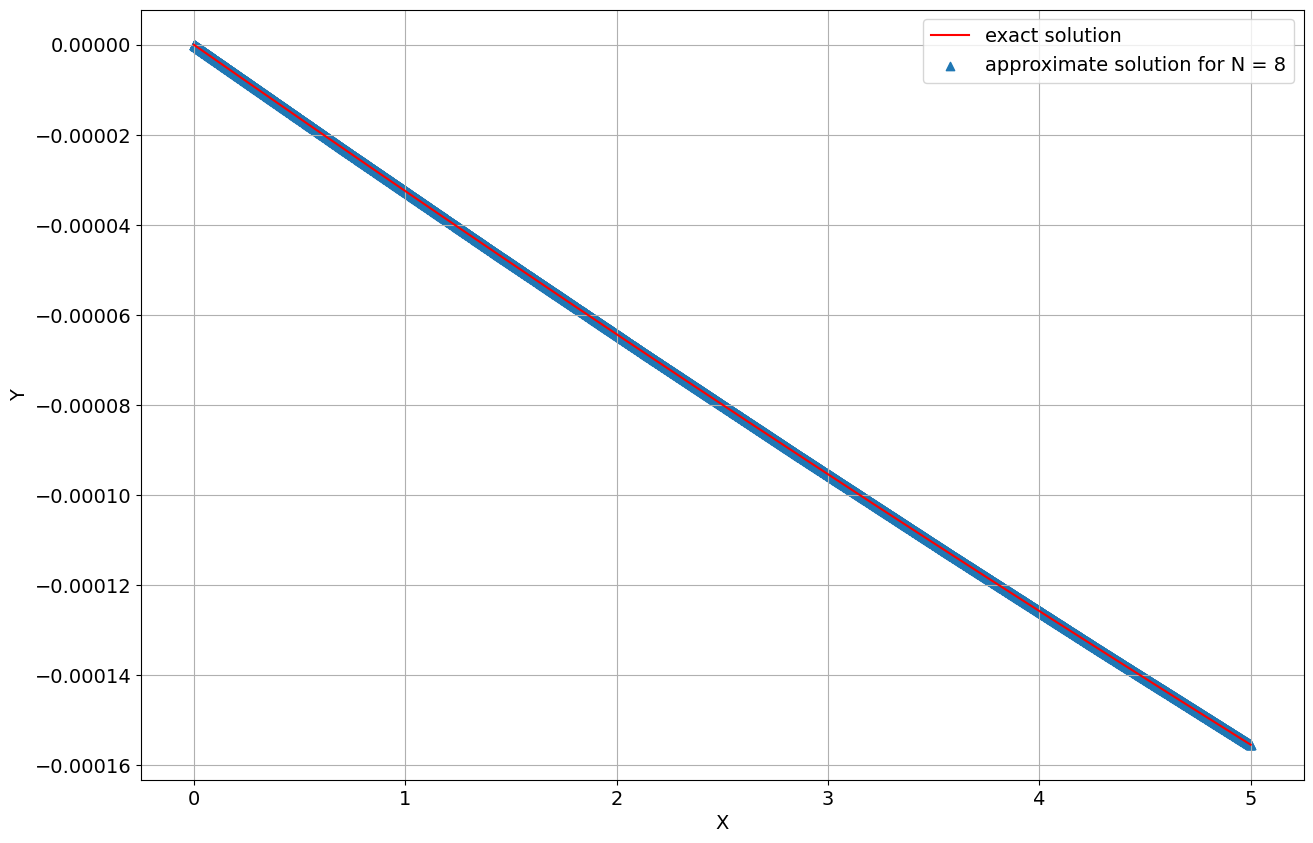

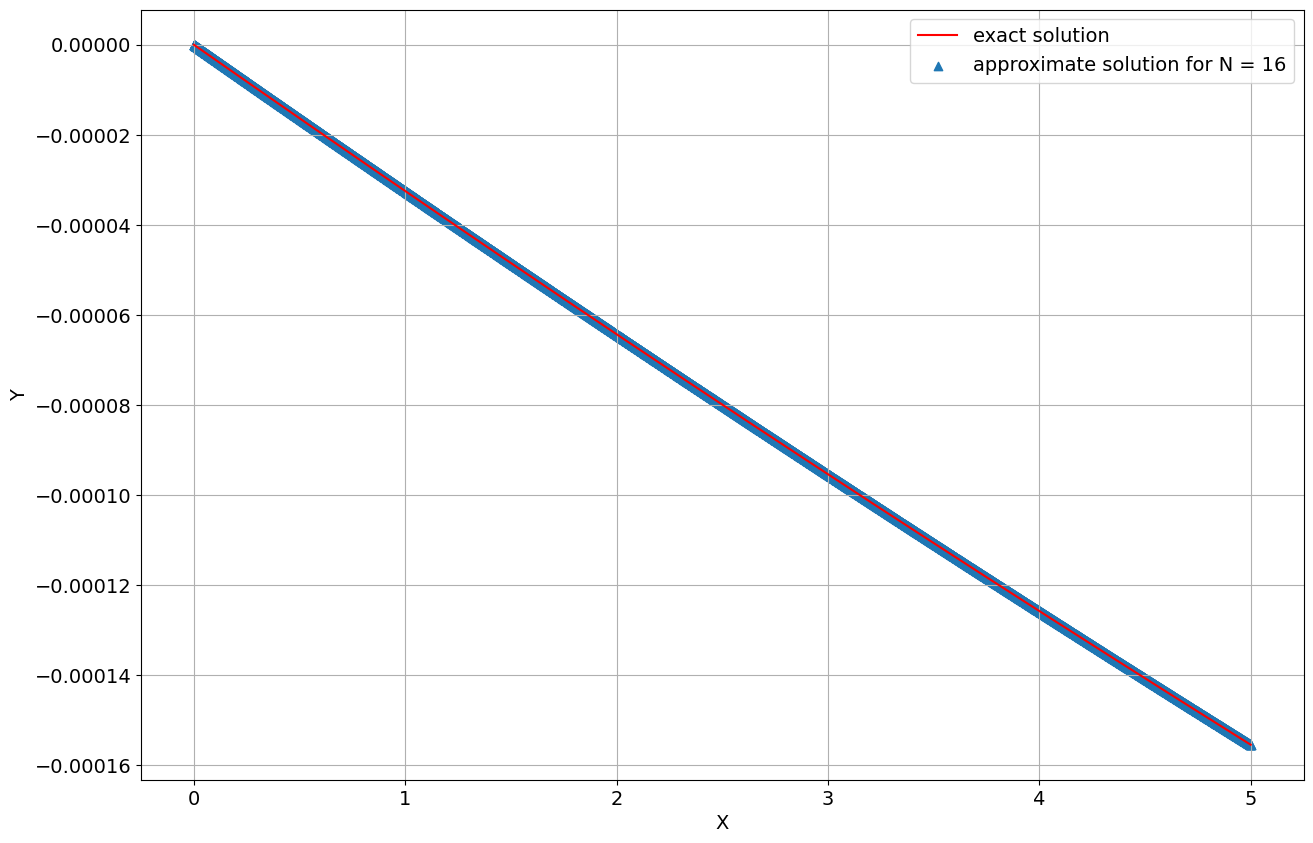

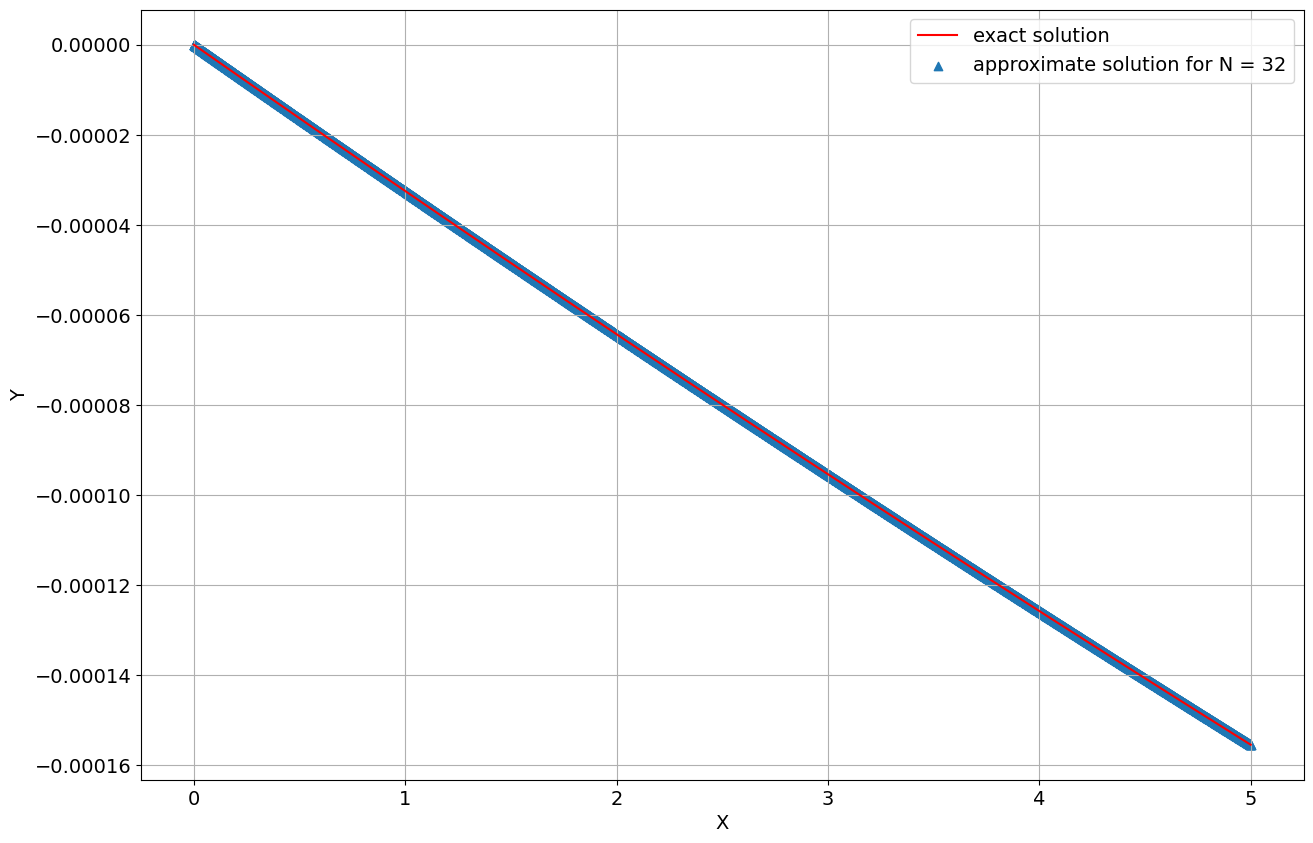

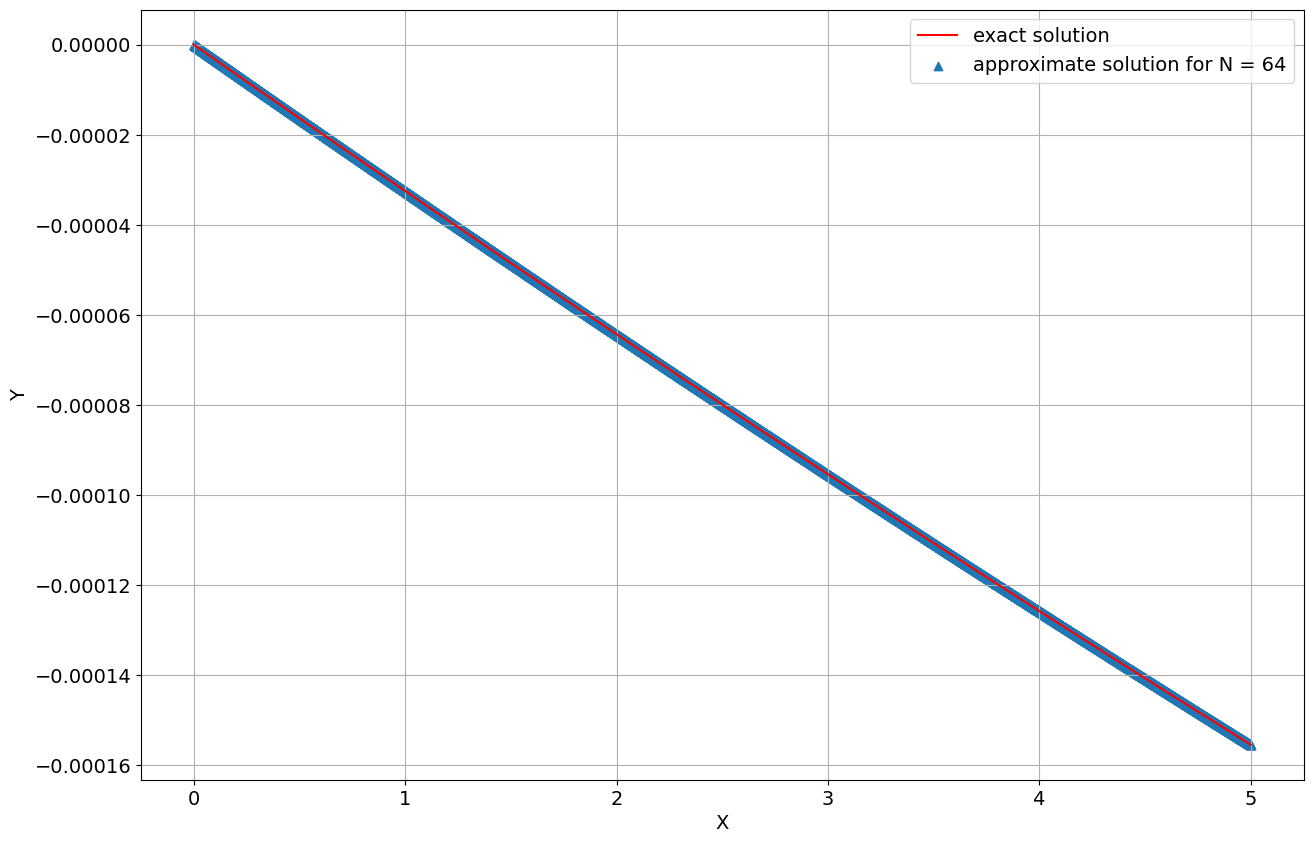

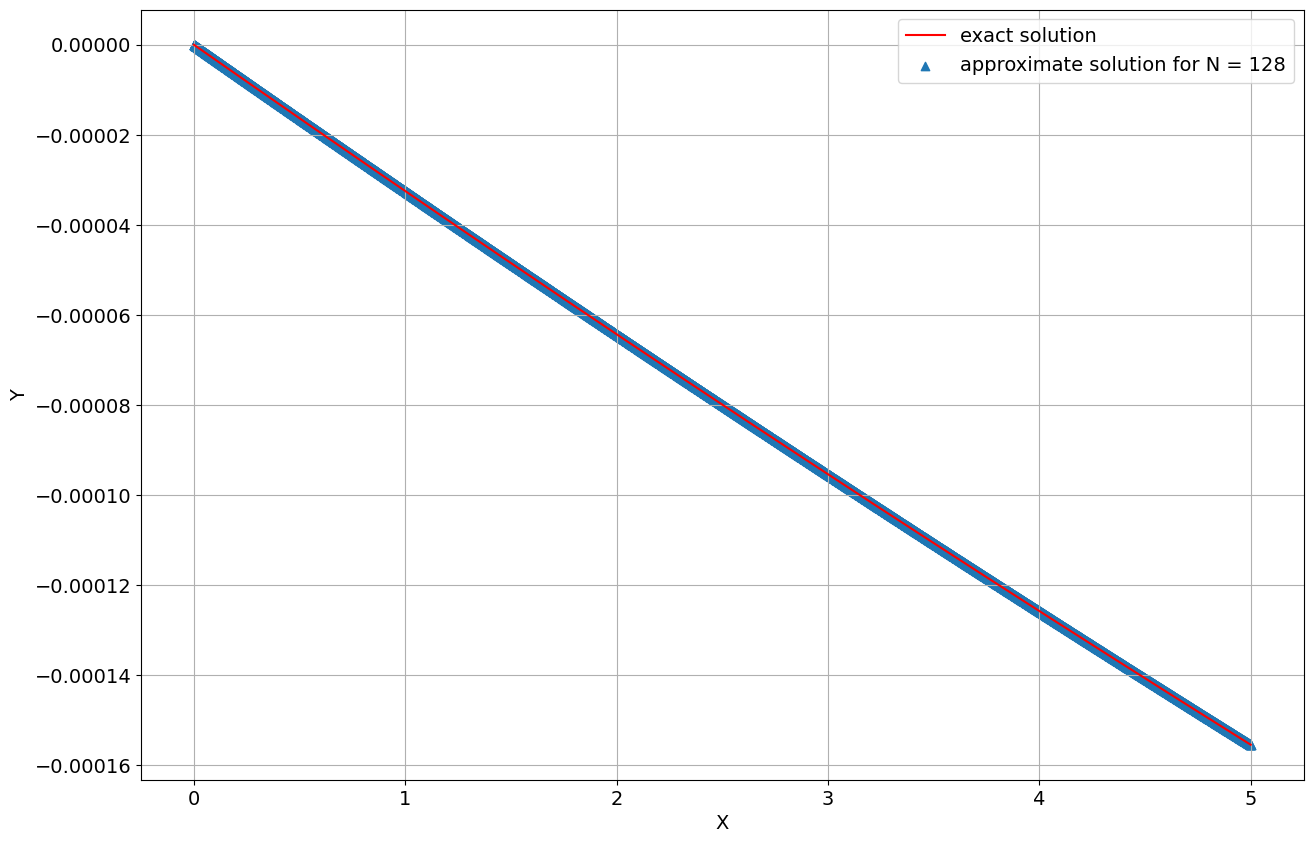

       N            Er         R        El         R       cond(K)   time, s
0    2.0  1.413648e-02  0.000000  0.017630  0.000000      1.000000  0.000706
1    4.0  1.570720e-03  3.169925  0.001959  3.169925     16.393732  0.000246
2    8.0  2.884996e-04  2.444785  0.000360  2.444785     87.566836  0.000329
3   16.0  6.282881e-05  2.199071  0.000078  2.199071    385.822396  0.000650
4   32.0  1.471018e-05  2.094611  0.000018  2.094611   1604.910972  0.000746
5   64.0  3.561721e-06  2.046168  0.000004  2.046167   6533.171439  0.001482
6  128.0  8.764637e-07  2.022808  0.000001  2.022810  26349.973353  0.006355


In [4]:
if __name__ == "__main__":
    arrAns = main()
    arrAnspd = pd.DataFrame(arrAns, columns=["N", "Er", "R", "El", "R", "cond(K)", "time, s"])
    print(arrAnspd)